In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf

In [3]:
SPY = pd.read_csv('SPY.csv', index_col = 0)
AAPL = pd.read_csv('AAPL.O.csv', index_col = 0)
AMZN = pd.read_csv('AMZN.O.csv', index_col = 0)
GOOG = pd.read_csv('GOOG.O.csv', index_col = 0)
META = pd.read_csv('META.O.csv', index_col = 0)
MSFT = pd.read_csv('MSFT.O.csv', index_col = 0)
NVDA = pd.read_csv('NVDA.O.csv', index_col = 0)
TSLA = pd.read_csv('TSLA.O.csv', index_col = 0)

In [4]:
Mag_7 = ['AAPL', 
         'MSFT', 
         'GOOG', 
         'AMZN', 
         'META', 
         'NVDA', 
         'TSLA']

In [5]:
data = pd.DataFrame(index = SPY.index)
data['SPY'] = SPY['Adj Close']
data['AAPL'] = AAPL['CLOSE']
data['MSFT'] = MSFT['CLOSE']
data['GOOG'] = GOOG['CLOSE']
data['AMZN'] = AMZN['CLOSE']
data['META'] = META['CLOSE']
data['NVDA'] = NVDA['CLOSE']
data['TSLA'] = TSLA['CLOSE']
data.dropna(inplace = True)

In [6]:
returns = data.pct_change()

In [7]:
mkt_cap = pd.DataFrame(index = AAPL.index)
mkt_cap['AAPL'] = AAPL['MKT_CAP_ARD']
mkt_cap['MSFT'] = MSFT['MKT_CAP_ARD']
mkt_cap['GOOG'] = GOOG['MKT_CAP_ARD']
mkt_cap['AMZN'] = AMZN['MKT_CAP_ARD']
mkt_cap['META'] = META['MKT_CAP_ARD']
mkt_cap['NVDA'] = NVDA['MKT_CAP_ARD']
mkt_cap['TSLA'] = TSLA['MKT_CAP_ARD']
mkt_cap.dropna(inplace = True)

In [8]:
interest_rate = pd.DataFrame(0, index = data.index, columns=["Rate"])

In [9]:
data.index[0], data.index[-1]

('2014-03-27', '2025-01-24')

In [4]:
# Backtest Params
lookback = 200
observe = 1
weigh_flag = "Equal"
Universe = ['AES', 'LNT', 'AEE', 'AEP', 'AWK', 'ATO', 'CNP', 'CMS', 'ED',"SPY"]

data = yf.download(Universe,start = '2020-1-1',end = '2025-1-1')['Close']
returns = data.pct_change().dropna()
interest_rate = pd.DataFrame(0, index = data.index, columns=["Rate"])
dates = []
hedged_returns = []
unhedged_returns = []

for i in range(lookback + 1, len(data.index) - observe):
    date = data.index[i]
    
    # Portfolio weights for this day
    if weigh_flag == "Market Cap":
        daily_mkt_cap = {ticker : mkt_cap.loc[date, ticker] for ticker in Universe}
        denominator = sum(daily_mkt_cap.values())
        portfolio = {ticker : daily_mkt_cap[ticker] / denominator for ticker in Universe}
    
    elif weigh_flag == "Equal":
        portfolio = {ticker : 1.0/7 for ticker in Universe}
    
    # Portfolio beta during lookback
    beta = {}
    return_samples = returns.iloc[i - lookback : i, :]
    rate_samples = interest_rate.iloc[i - lookback : i, :]
    
    for ticker in Universe:
        X = return_samples["SPY"] - rate_samples["Rate"]  # Currently Assumed 0
        y = return_samples[ticker] - rate_samples["Rate"]
        
        X = sm.add_constant(X)
        
        model = sm.OLS(y, X).fit()
        beta[ticker] = model.params.iloc[1]
        
    portfolio_beta = sum([beta[ticker] * portfolio[ticker] for ticker in Universe])
    
    hedged = portfolio.copy()
    unhedged = portfolio.copy()
    hedged['SPY'] = -portfolio_beta
    unhedged['SPY'] = 0
    
    hedged_return = sum([returns[ticker].iloc[i] * hedged[ticker] for ticker in hedged])
    unhedged_return = sum([returns[ticker].iloc[i] * unhedged[ticker] for ticker in unhedged])
    
    dates.append(date)
    hedged_returns.append(hedged_return)
    unhedged_returns.append(unhedged_return)

[*********************100%***********************]  10 of 10 completed


MissingDataError: exog contains inf or nans

In [38]:
result = pd.DataFrame({'Hedged': hedged_returns,
                      'Unhedged': unhedged_returns},
                     index = dates)

,Hedged,Unhedged
2015-01-29,0.010741,0.021687
2015-01-30,0.020990,0.005941
2015-02-02,-0.006054,0.008524
2015-02-03,-0.013959,0.002897
2015-02-04,0.006706,0.002335


In [47]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=result.index, y=result["Unhedged"], 
                         mode='lines', name="Unhedged", 
                         line=dict(color='#CDAA00')))


fig.add_trace(go.Scatter(x=result.index, y=result["Hedged"], 
                         mode='lines', name="Hedged", 
                         line=dict(color='blue')))

fig.update_layout(title="Hedged vs. Unhedged Returns",
                  xaxis_title="Date",
                  yaxis_title="Returns",
                  plot_bgcolor="white",
                  paper_bgcolor="white")

fig.show()

In [53]:
window_size = 500

hedged_var = result['Hedged'].rolling(window = window_size).var()
unhedged_var = result['Unhedged'].rolling(window = window_size).var()

effectiveness = 1 - (hedged_var / unhedged_var)

result['Effectiveness'] = effectiveness

temp = result.dropna()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=temp.index, 
    y=temp["Effectiveness"], 
    mode='lines', 
    name="Effectiveness",
    line=dict(color="blue")
))

fig.update_layout(
    title="Hedging Effectiveness",
    xaxis_title="Date",
    yaxis_title="",
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(size=12),
)

fig.show()

In [11]:
lookback = 100
observe = 100
weigh_flag = "Market Cap"
beta_STD = 0.2

i = lookback + 1
date = data.index[i]

daily_mkt_cap = {ticker : mkt_cap.loc[date, ticker] for ticker in Mag_7}
denominator = sum(daily_mkt_cap.values())
portfolio = {ticker : daily_mkt_cap[ticker] / denominator for ticker in Mag_7}

beta = {}
return_samples = returns.iloc[i - lookback : i, :]
rate_samples = interest_rate.iloc[i - lookback : i, :]

for ticker in Mag_7:
    X = return_samples["SPY"] - rate_samples["Rate"]  # Currently Assumed 0
    y = return_samples[ticker] - rate_samples["Rate"]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    beta[ticker] = model.params.iloc[1]
    
portfolio_beta = sum([beta[ticker] * portfolio[ticker] for ticker in Mag_7])

# Sample with Gaussian Distribution N(portfolio_beta, beta_STD)
normal_betas = np.random.normal(loc = portfolio_beta, scale = beta_STD, size = 1000)
return_results = []

return_samples = returns.iloc[i : i + observe, :]
beta_return_sets = []

for sample_beta in normal_betas:
    portfolio["SPY"] = -sample_beta
    portfolio_returns = []
    
    for future_date in return_samples.index:
        daily_return = sum([return_samples.loc[future_date, ticker] * portfolio[ticker] for ticker in portfolio])
        portfolio_returns.append(daily_return)
        
    return_results.append(np.mean(portfolio_returns) * 250)
    beta_return_sets.append((sample_beta, np.mean(portfolio_returns) * 250))

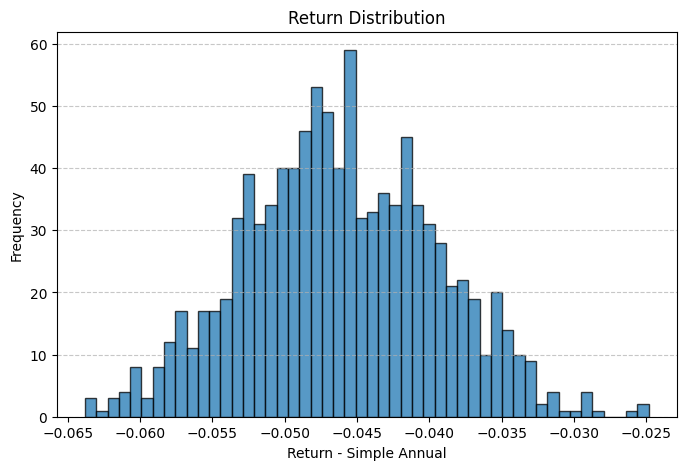

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(return_results, bins=50, edgecolor="black", alpha=0.75)

plt.xlabel("Return - Simple Annual")
plt.ylabel("Frequency")
plt.title("Return Distribution")

# Show grid and plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()